<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/Diffusion/Hugging%20Face/3_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stable Diffusion Deep Dive: https://www.youtube.com/watch?app=desktop&v=0_BBRNYInx8

DreamBooth Fine-Tuning: https://dreambooth.github.io/
  *    For Stable Dİffusion: https://huggingface.co/docs/diffusers/training/dreambooth
  *    Parameter Sensitivity: https://huggingface.co/blog/dreambooth
  *    Hackathon Folder: https://github.com/huggingface/diffusion-models-class/tree/main/hackathon


In [1]:
%pip install -Uq diffusers ftfy accelerate
%pip install -Uq git+https://github.com/huggingface/transformers

import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

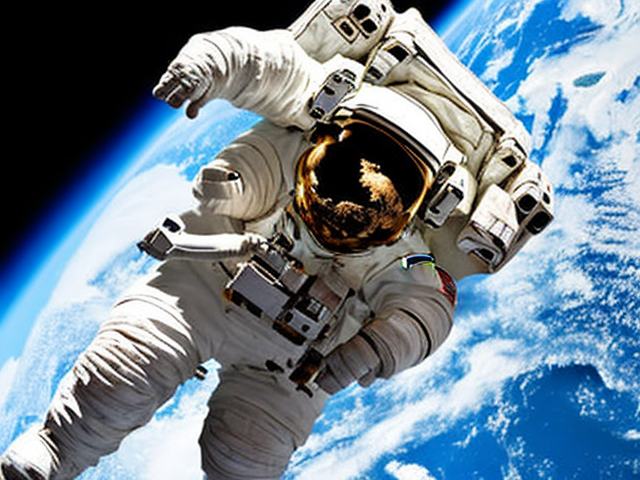

In [5]:
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
#pipe.enable_attention_slicing() (if out of GPU memory)

generator = torch.Generator(device=device).manual_seed(42)

pipe_output = pipe(
    prompt="An astronaut watching the earth outter space",
    negative_prompt="Oversaturated, blurry, low quality",
    height=480,
    width=640,  # Specify the image size
    guidance_scale=8,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

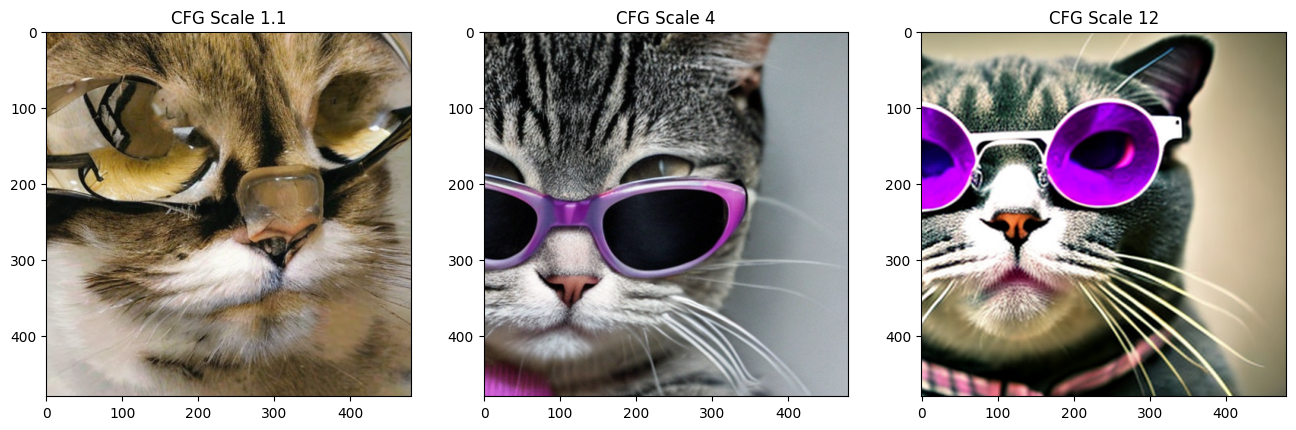

In [8]:
cfg_scales = [1.1, 4, 12]
prompt = "Scottish cat with a pink glasses"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35
    ).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


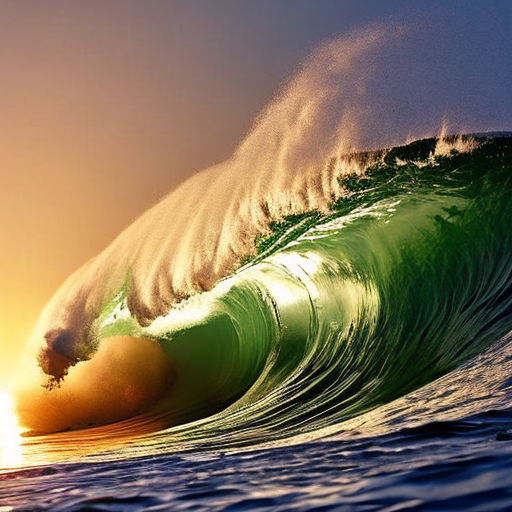

In [4]:
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

generator = torch.Generator(device=device).manual_seed(42)

guidance_scale = 8
num_inference_steps = 30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

Notebook: https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb

Video: https://www.youtube.com/watch?app=desktop&v=0_BBRNYInx8

## Img2Img
---


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Result')

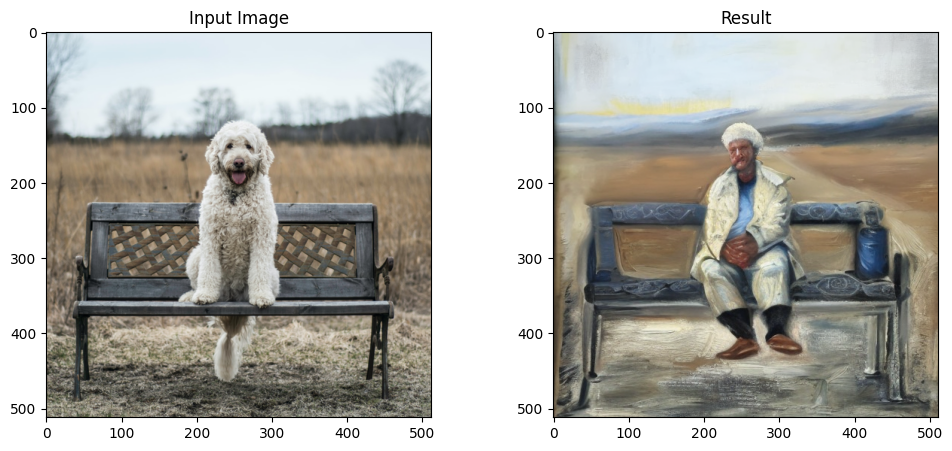

In [5]:
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image,  # The starting image
    strength=0.6,  # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

## In-Painting
---

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Result')

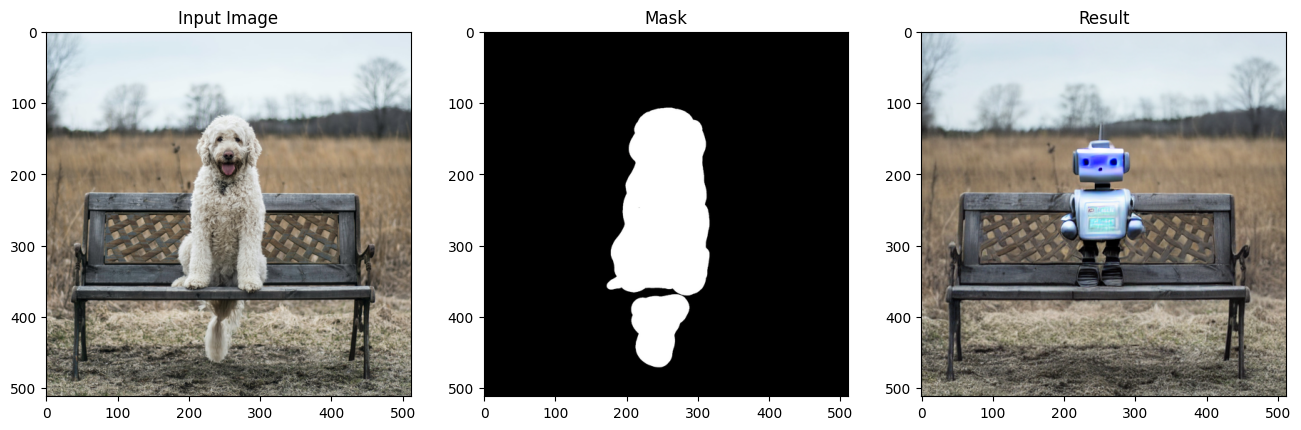

In [15]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("benjamin-paine/stable-diffusion-v1-5-inpainting", variant="fp16", torch_dtype=torch.float16)
pipe = pipe.to(device)

# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(mask_image)
axs[1].set_title("Mask")
axs[2].imshow(image)
axs[2].set_title("Result")

CLIPSeg can be used to mask out and object to be replaced based on a text description.

## Depth2Image
---

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Result')

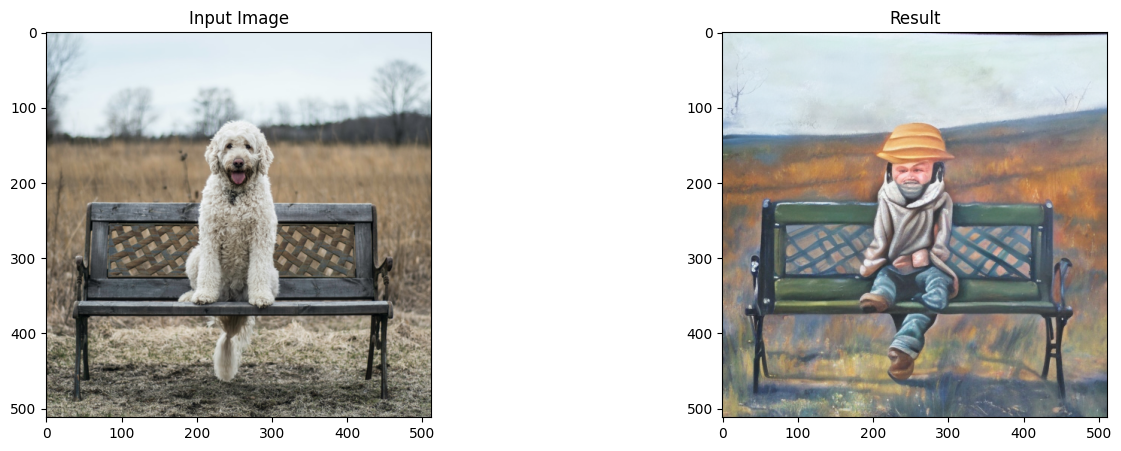

In [18]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(image)
axs[1].set_title("Result")